In [1]:
#!/usr/bin/env python
# coding: utf-8
# In[1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.datasets as datasets
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap

In [2]:
#Function for plotting
from mpl_toolkits.mplot3d import Axes3D

def scatterPlot(x, y, points_labels, algoName, size = (4,3), x_label ='1. główna składowa',
                y_label = '2. główna składowa', show_legend =True):
    fig = plt.figure(figsize = size)
    ax = fig.add_subplot(111)
    colormap = get_cmap('tab20')
    n = len(np.unique(points_labels))
    if n == 1:
        cdict = [rgb2hex((0,0,0))]
    if n > 1:
        cdict = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01,
                                                             1/(n-1))]
    color_iter = 0
    for g in np.unique(points_labels):
        ix = np.where(points_labels == g)[0]
        ax.scatter(x[ix], y[ix], c = cdict[color_iter], label = g, s = 5)
        color_iter += 1
        
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(algoName)
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.set_xlabel(x_label)
    lgnd = plt.legend(loc="lower left", scatterpoints=10, fontsize=10)
    
    for handle in lgnd.legendHandles:
        handle.set_sizes([6.0])
        
    ax.set_ylabel(y_label)
    if show_legend:
        ax.legend(loc='best')
        
    return ax

In [3]:
def plotDendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,counts]).astype(float)
    
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [4]:
def analyzeClusters(labels, real_labels):
    clusters, counts = np.unique(labels, return_counts = True)
    real_lab_perc = pd.DataFrame()
    
    for g in np.unique(labels):
        idx = np.where(labels == g)[0]
        cluster_real_labels = np.asarray(real_labels)[idx]
        cluster_labels = np.asarray(labels)[idx]
        real_label_in, real_lab_counts = np.unique(np.asarray(real_labels)[idx], return_counts = True)
        percent = 100*real_lab_counts/sum(real_lab_counts)
        xx = pd.DataFrame([percent], index = [g], columns =
        np.unique(real_label_in))
        real_lab_perc = pd.concat([real_lab_perc, xx], axis = 1)

    real_lab_perc=real_lab_perc.groupby(by=real_lab_perc.columns,axis=1).sum()
    clusters_table = np.asarray([clusters, counts]).T
    clusters_table = pd.DataFrame(clusters_table, columns = ['klaster','liczba obiektów'])
    clusters_table.reset_index(drop=True, inplace=True)
    real_lab_perc.reset_index(drop=True, inplace=True)
    
    df = pd.concat( [clusters_table, real_lab_perc], axis=1)
    return df.round(1)

In [5]:
def cutSmallest(labels, cut_num):
    clusters, counts = np.unique(labels, return_counts = True)
    cutoff_labels=labels
    for cluster, count in zip(clusters, counts):
        if count <= cut_num:
            for idx, label in enumerate(cutoff_labels):
                if label == cluster:
                    cutoff_labels[idx] = -1
    return cutoff_labels

In [6]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

In [7]:
def evalScores(data, labels_arr):
    silhuette_scores = []
    CH_scores = []
    DB_scores = []
    for labels in labels_arr:
        silhuette_scores.append(silhouette_score(data, labels))
        CH_scores.append(calinski_harabasz_score(data, labels))
        DB_scores.append(davies_bouldin_score(data, labels))
    return silhuette_scores, CH_scores, DB_scores

In [8]:
data = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531/data.csv")
real_labels = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531/labels.csv")

In [9]:
data.head(5).round(2)

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.02,3.27,5.48,10.43,0.0,7.18,0.59,0.0,...,4.93,8.21,9.72,7.22,9.12,12.00,9.65,8.92,5.29,0.0
1,sample_1,0.0,0.59,1.59,7.59,9.62,0.0,6.82,0.00,0.0,...,4.59,7.32,9.74,6.26,8.38,12.67,10.52,9.40,2.09,0.0
2,sample_2,0.0,3.51,4.33,6.88,9.87,0.0,6.97,0.45,0.0,...,5.13,8.13,10.91,5.40,9.91,9.05,9.79,10.09,1.68,0.0
3,sample_3,0.0,3.66,4.51,6.66,10.20,0.0,7.84,0.43,0.0,...,6.08,8.79,10.14,8.94,9.60,11.39,9.69,9.68,3.29,0.0
4,sample_4,0.0,2.66,2.82,6.54,9.74,0.0,6.57,0.36,0.0,...,6.00,8.89,10.37,7.18,9.85,11.92,9.22,9.46,5.11,0.0


In [10]:
data = data.drop(columns = ["Unnamed: 0"])

In [11]:
data.columns = data.columns.str.replace("gene_", "gen ")

In [12]:
beginning=data.describe()[data.describe().columns[0:9]].round(2)

In [13]:
pd.DataFrame(beginning)

,gen 0,gen 1,gen 2,gen 3,gen 4,gen 5,gen 6,gen 7,gen 8
count,801.00,801.00,801.00,801.00,801.00,801.0,801.00,801.00,801.00
mean,0.03,3.01,3.10,6.72,9.81,0.0,7.41,0.50,0.02
std,0.14,1.20,1.07,0.64,0.51,0.0,1.11,0.51,0.13
min,0.00,0.00,0.00,5.01,8.44,0.0,3.93,0.00,0.00
25%,0.00,2.30,2.39,6.30,9.46,0.0,6.68,0.00,0.00
50%,0.00,3.14,3.13,6.66,9.79,0.0,7.45,0.44,0.00
75%,0.00,3.88,3.80,7.04,10.14,0.0,8.12,0.79,0.00
max,1.48,6.24,6.06,10.13,11.36,0.0,10.72,2.78,1.79


In [14]:
real_labels.describe()

,Unnamed: 0,Class
count,801,801
unique,801,5
top,sample_663,BRCA
freq,1,300


In [15]:
real_labels = real_labels.drop(columns=['Unnamed: 0'])

In [16]:
real_labels

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA
...,...
796,BRCA
797,LUAD
798,COAD
799,PRAD


In [17]:
np.unique(real_labels)

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [18]:
real_labels.describe()

,Class
count,801
unique,5
top,BRCA
freq,300


In [19]:
nullCounter = data.isnull().sum().sort_values(ascending = False)
nullCounter.head()

gen 20530    0
gen 6736     0
gen 6838     0
gen 6839     0
gen 6840     0
dtype: int64

In [20]:
nanCounter = data.isna().sum().sort_values(ascending = False)
nanCounter.head()

gen 20530    0
gen 6736     0
gen 6838     0
gen 6839     0
gen 6840     0
dtype: int64

In [21]:
scaled_data = np.asarray(data)
scaled_data = StandardScaler().fit_transform(scaled_data)

In [22]:
pd.DataFrame(scaled_data).head()

,0,1,2,3,4,5,6,7,8,9,...,20521,20522,20523,20524,20525,20526,20527,20528,20529,20530
0,-0.194799,-0.828030,0.159800,-1.948277,1.221575,0.0,-0.207968,0.180910,-0.125376,-0.065633,...,-1.300200,-0.921755,-0.877838,0.996247,-1.166072,0.389441,-0.869566,-1.187938,-0.116483,-0.261901
1,-0.194799,-2.015017,-1.415042,1.353109,-0.376518,0.0,-0.532222,-0.983088,-0.125376,-0.065633,...,-1.747076,-2.392213,-0.831893,0.591649,-2.549598,1.391628,0.623551,-0.342277,-1.656889,-0.261901
2,-0.194799,0.417348,1.156735,0.249807,0.112832,0.0,-0.391297,-0.092995,-0.125376,-0.065633,...,-1.034088,-1.059669,2.248803,0.232601,0.317880,-4.025621,-0.632381,0.886860,-1.855264,-0.261901
3,-0.194799,0.543888,1.326182,-0.099053,0.755741,0.0,0.395348,-0.127831,-0.125376,-0.065633,...,0.241299,0.044905,0.224956,1.719725,-0.263847,-0.521747,-0.793609,0.166174,-1.078941,-0.261901
4,-0.194799,-0.295955,-0.257107,-0.286413,-0.148843,0.0,-0.757118,-0.273165,-0.125376,-0.065633,...,0.133335,0.208252,0.837739,0.979924,0.196645,0.268992,-1.615841,-0.229878,-0.201588,-0.261901


In [23]:
data_df_sc = pd.DataFrame(scaled_data, columns = data.columns)
data_df_sc.head().round(2)

,gen 0,gen 1,gen 2,gen 3,gen 4,gen 5,gen 6,gen 7,gen 8,gen 9,...,gen 20521,gen 20522,gen 20523,gen 20524,gen 20525,gen 20526,gen 20527,gen 20528,gen 20529,gen 20530
0,-0.19,-0.83,0.16,-1.95,1.22,0.0,-0.21,0.18,-0.13,-0.07,...,-1.30,-0.92,-0.88,1.00,-1.17,0.39,-0.87,-1.19,-0.12,-0.26
1,-0.19,-2.02,-1.42,1.35,-0.38,0.0,-0.53,-0.98,-0.13,-0.07,...,-1.75,-2.39,-0.83,0.59,-2.55,1.39,0.62,-0.34,-1.66,-0.26
2,-0.19,0.42,1.16,0.25,0.11,0.0,-0.39,-0.09,-0.13,-0.07,...,-1.03,-1.06,2.25,0.23,0.32,-4.03,-0.63,0.89,-1.86,-0.26
3,-0.19,0.54,1.33,-0.10,0.76,0.0,0.40,-0.13,-0.13,-0.07,...,0.24,0.04,0.22,1.72,-0.26,-0.52,-0.79,0.17,-1.08,-0.26
4,-0.19,-0.30,-0.26,-0.29,-0.15,0.0,-0.76,-0.27,-0.13,-0.07,...,0.13,0.21,0.84,0.98,0.20,0.27,-1.62,-0.23,-0.20,-0.26


In [24]:
xxx=data_df_sc.describe()[data_df_sc.describe().columns[0:9]].round(2)
pd.DataFrame(xxx)

,gen 0,gen 1,gen 2,gen 3,gen 4,gen 5,gen 6,gen 7,gen 8
count,801.00,801.00,801.00,801.00,801.00,801.0,801.00,801.00,801.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.0,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,0.0,1.00,1.00,1.00
min,-0.19,-2.51,-2.91,-2.68,-2.72,0.0,-3.14,-0.98,-0.13
25%,-0.19,-0.59,-0.66,-0.66,-0.69,0.0,-0.66,-0.98,-0.13
50%,-0.19,0.11,0.03,-0.10,-0.04,0.0,0.04,-0.11,-0.13
75%,-0.19,0.73,0.66,0.50,0.65,0.0,0.65,0.57,-0.13
max,10.64,2.69,2.79,5.34,3.05,0.0,2.99,4.48,13.24


In [25]:
#perform PCA
pca = PCA()
data_PCA = pca.fit_transform(scaled_data)
np.shape(data_PCA)

(801, 801)

Text(0, 0.5, 'skumulowana wariancja [%]')

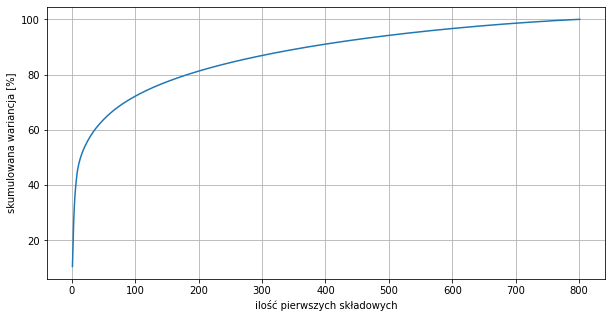

In [27]:
fig_variance, ax = plt.subplots(figsize = (10,5))
ax.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),
100*np.cumsum(pca.explained_variance_ratio_), label = 'skumulowana wariancja')
ax.grid()
ax.set_xlabel("ilość pierwszych składowych")
ax.set_ylabel("skumulowana wariancja [%]")

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity = 40, n_iter = 1000, metric = 'euclidean')
data_tsne = tsne.fit_transform(data_PCA[:,0:30])

<AxesSubplot:title={'center':' '}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

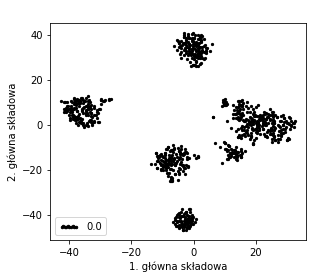

In [29]:
x_tsne, y_tsne = data_tsne[:,0], data_tsne[:,1]
scatterPlot(x_tsne, y_tsne, np.zeros(801),algoName = " ", size=(5.75,4), show_legend = False)

<AxesSubplot:title={'center':' '}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

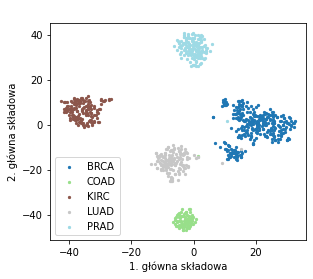

In [30]:
x_tsne, y_tsne = data_tsne[:,0], data_tsne[:,1]
scatterPlot(x_tsne, y_tsne, real_labels,algoName = " ", size=(5.75,4) ,show_legend = True)

<AxesSubplot:title={'center':' '}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

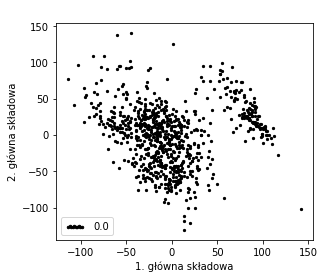

In [31]:
x_pca, y_pca, z_pca = data_PCA[:,0], data_PCA[:,1], data_PCA[:,2]
scatterPlot(x_pca, y_pca, np.zeros(801), " ",size=(5.75,4) , show_legend
= False)

In [32]:
pca.explained_variance_ratio_[0]
pca.explained_variance_ratio_[1]

0.08754232469325524

<AxesSubplot:title={'center':' '}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

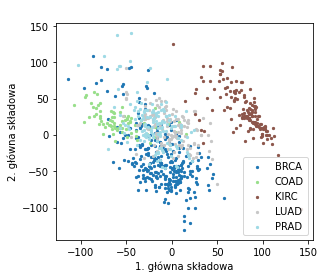

In [33]:
x_pca, y_pca, z_pca = data_PCA[:,0], data_PCA[:,1], data_PCA[:,3]
scatterPlot(x_pca, y_pca, real_labels, " ",size=(5.75,4) , show_legend =
True)

In [34]:
data_PCA = data_PCA[:,:300]

In [35]:
#calculating clustering quality indexes values for plot
labels_arr = []
clusters_range = range(2,21)
for k in clusters_range:
    kmeans = KMeans(n_clusters = k, random_state = 42,).fit(data_PCA)
    labels_arr.append(kmeans.labels_)
    
silhuette_scores, CH_scores, DB_scores = evalScores(data_PCA[:, :100],labels_arr)

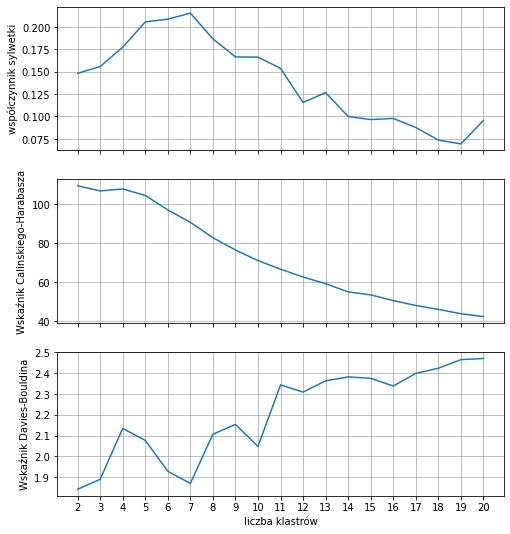

In [36]:
#plotting clustering quality values
fig, (silhuette, CH, DB) = plt.subplots(nrows=3, figsize=(8, 9),
ncols=1, sharex=True)
silhuette.plot(clusters_range, silhuette_scores)
silhuette.grid()
silhuette.set_ylabel(ylabel = "współczynnik sylwetki")
CH.plot(clusters_range, CH_scores)
CH.grid()
CH.set_ylabel(ylabel = "Wskaźnik Calinskiego-Harabasza")
DB.plot(clusters_range, DB_scores)
DB.grid()
DB.set_xlabel(xlabel = "liczba klastrów")
DB.set_ylabel(ylabel = "Wskaźnik Davies-Bouldina")
DB.set_xticks(np.arange(2,21))

<AxesSubplot:title={'center':'algorytm K-średnich'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

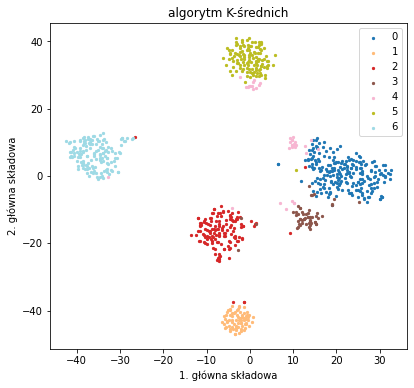

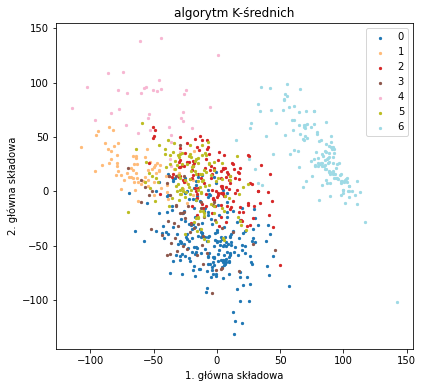

In [37]:
# # Algorytm K-średnich
opt_k = 7
kmeans = KMeans(opt_k, random_state = 10).fit(data_PCA)
scatterPlot(x_tsne, y_tsne, kmeans.labels_, "algorytm K-średnich", size
= (8,6))
scatterPlot(x_pca, y_pca, kmeans.labels_, "algorytm K-średnich", size =
(8,6))

In [38]:
analyzeClusters(kmeans.labels_, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,0,225,100.0,0.0,0.0,0.0,0.0
1,1,74,0.0,100.0,0.0,0.0,0.0
2,2,142,0.7,2.8,0.7,95.8,0.0
3,3,55,92.7,0.0,0.0,7.3,0.0
4,4,37,62.2,0.0,2.7,2.7,32.4
5,5,124,0.0,0.0,0.0,0.0,100.0
6,6,144,0.0,0.0,100.0,0.0,0.0


<AxesSubplot:title={'center':'algorytm K-średnich'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

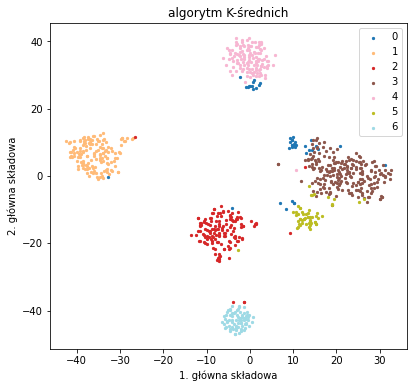

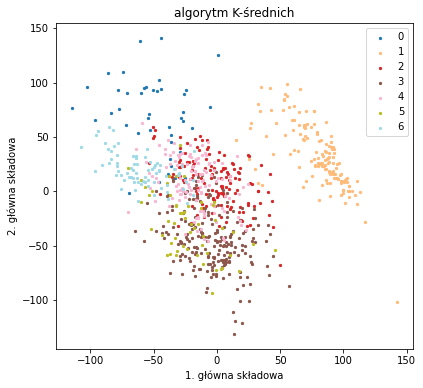

In [39]:
opt_k = 7
kmeans = KMeans(opt_k, random_state = 42).fit(data_PCA)
scatterPlot(x_tsne, y_tsne, kmeans.labels_, "algorytm K-średnich", size
= (8,6))
scatterPlot(x_pca, y_pca, kmeans.labels_, "algorytm K-średnich", size =
(8,6))

In [40]:
analyzeClusters(kmeans.labels_, real_labels).to_clipboard

<bound method NDFrame.to_clipboard of    klaster  liczba obiektów   BRCA   COAD   KIRC  LUAD   PRAD
0        0               42   66.7    0.0    2.4   2.4   28.6
1        1              144    0.0    0.0  100.0   0.0    0.0
2        2              144    0.7    2.8    0.7  95.8    0.0
3        3              218  100.0    0.0    0.0   0.0    0.0
4        4              124    0.0    0.0    0.0   0.0  100.0
5        5               55   96.4    0.0    0.0   3.6    0.0
6        6               74    0.0  100.0    0.0   0.0    0.0>

In [41]:
## DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=6, metric = 'correlation')
dbscan.fit(data_PCA)

DBSCAN(metric='correlation', min_samples=6)

<AxesSubplot:title={'center':'Rzeczywiste cyfry'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

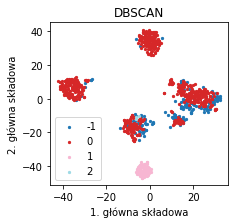

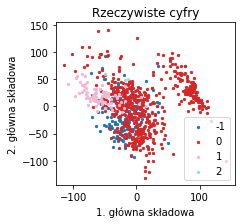

In [42]:
scatterPlot(x_tsne, y_tsne, dbscan.labels_,"DBSCAN")
scatterPlot(x_pca, y_pca, dbscan.labels_, "Rzeczywiste cyfry")

min_pts =  2
min_pts =  4
min_pts =  6
min_pts =  8
min_pts =  10
min_pts =  12
min_pts =  14
min_pts =  16
min_pts =  18
min_pts =  20
min_pts =  22
min_pts =  24
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



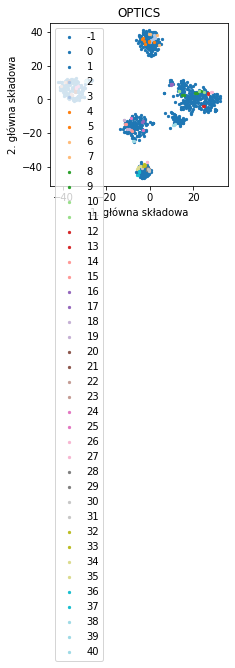

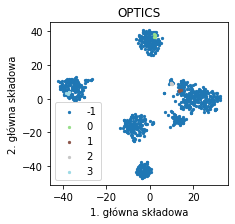

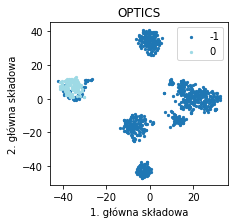

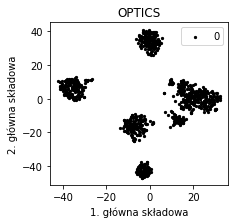

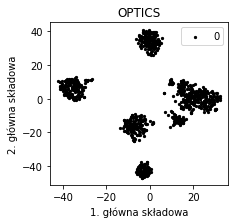

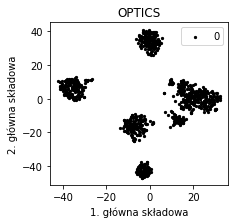

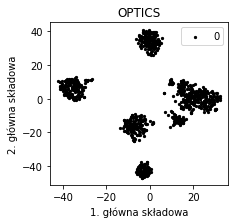

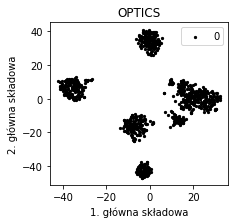

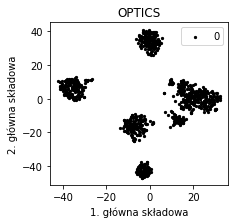

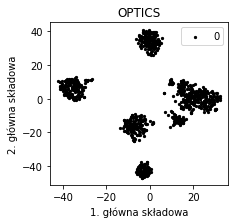

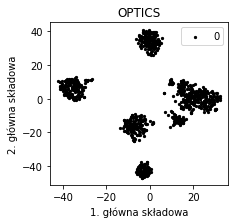

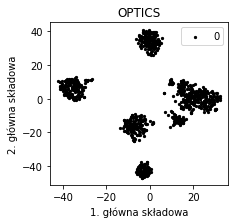

In [43]:
from sklearn.cluster import OPTICS
for min_pts in range(2,25,2):
    print('min_pts = ', min_pts)
    optics = OPTICS(min_samples = min_pts, metric ='euclidean').fit(data_PCA)
    scatterPlot(x_tsne, y_tsne, optics.labels_,"OPTICS", size = (4,3))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n")

<AxesSubplot:title={'center':'OPTICS'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

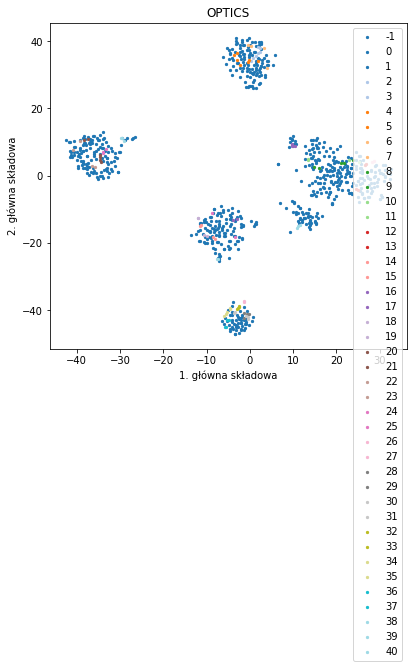

In [44]:
optics = OPTICS(min_samples = 2, metric = 'euclidean').fit(data_PCA)
scatterPlot(x_tsne, y_tsne, optics.labels_,"OPTICS", size = (8,6))

In [45]:
analyzeClusters(optics.labels_, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,-1,699,39.6,7.7,18.6,18.2,15.9
1,0,4,0.0,0.0,0.0,0.0,100.0
2,1,3,0.0,0.0,0.0,0.0,100.0
3,2,3,0.0,0.0,0.0,0.0,100.0
4,3,4,0.0,0.0,0.0,0.0,100.0
5,4,4,0.0,0.0,0.0,0.0,100.0
6,5,3,0.0,0.0,0.0,0.0,100.0
7,6,2,0.0,0.0,0.0,0.0,100.0
8,7,2,0.0,0.0,0.0,0.0,100.0
9,8,2,100.0,0.0,0.0,0.0,0.0


min_pts =  2
min_pts =  3
min_pts =  4
min_pts =  5
min_pts =  6
min_pts =  7
min_pts =  8
min_pts =  9
min_pts =  10
min_pts =  11
min_pts =  12
min_pts =  13
min_pts =  14
min_pts =  15
min_pts =  16
min_pts =  17
min_pts =  18
min_pts =  19
min_pts =  20
min_pts =  21
min_pts =  22


<ipython-input-2-c8fe848d0de5>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = size)


min_pts =  23
min_pts =  24
min_pts =  25
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



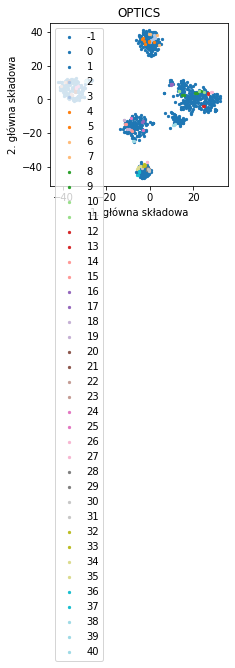

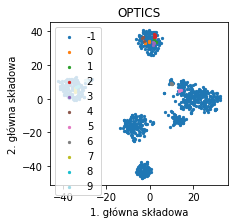

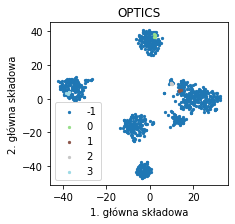

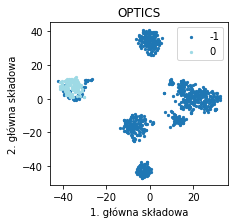

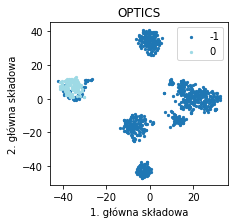

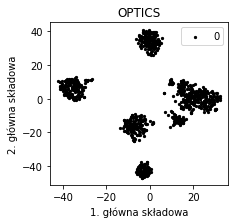

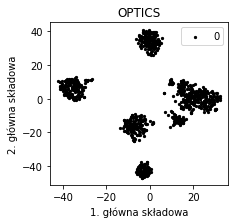

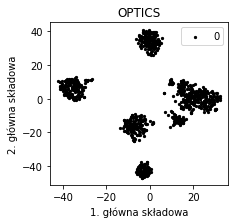

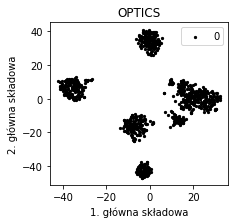

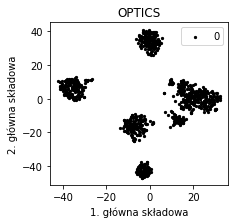

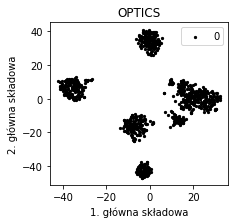

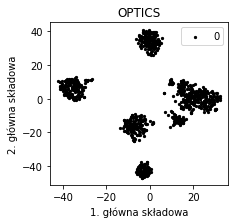

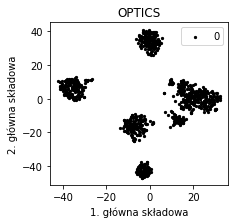

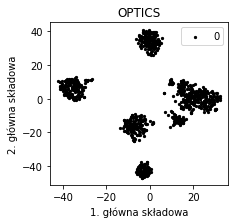

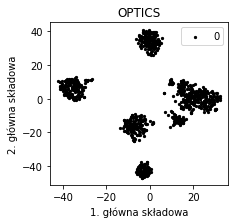

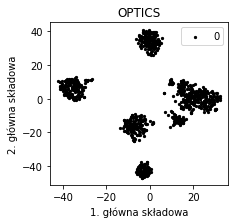

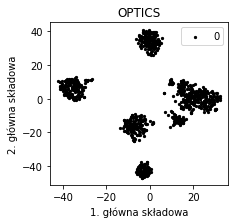

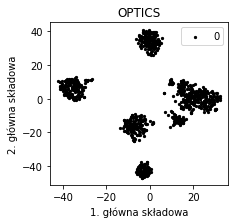

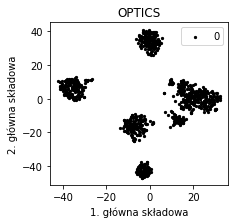

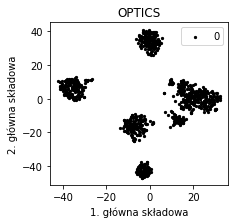

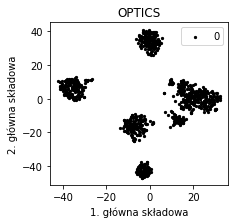

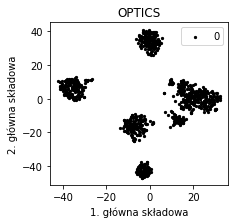

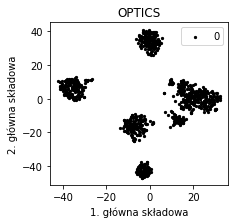

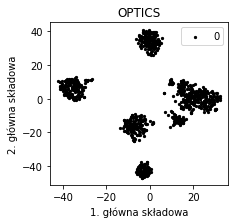

In [46]:
for min_pts in range(2,26):
    print('min_pts = ', min_pts)
    optics = OPTICS(min_samples = min_pts, metric =
    'euclidean').fit(data_PCA)
    scatterPlot(x_tsne, y_tsne, optics.labels_,"OPTICS", size = (4,3))
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n")

min_pts =  2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  11
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  12
%%%%

<ipython-input-2-c8fe848d0de5>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize = size)


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  23
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  24
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  25
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  26
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  27
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  28
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  29
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  30
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  31
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

min_pts =  32
%%%%%%%%%%

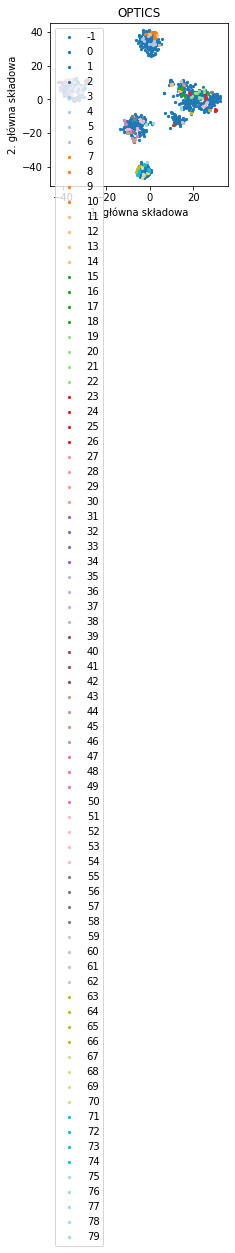

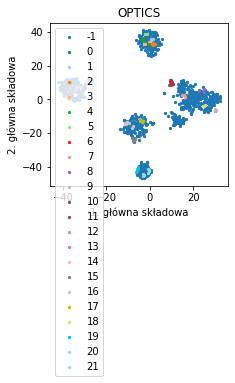

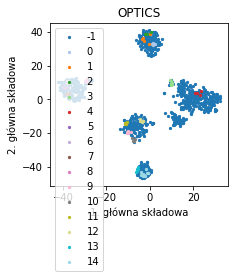

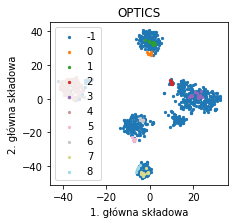

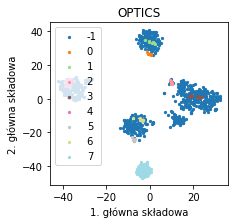

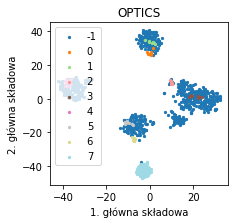

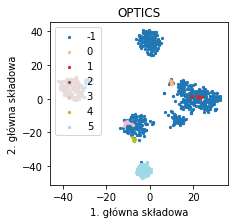

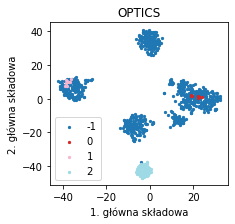

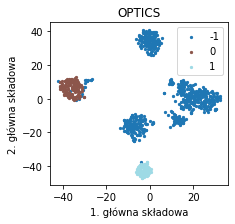

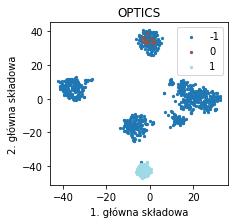

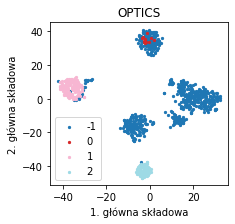

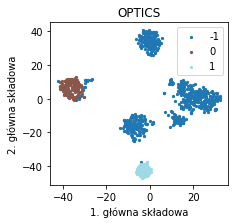

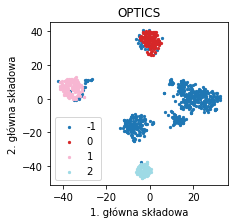

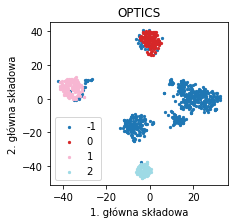

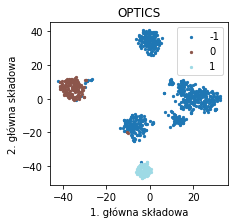

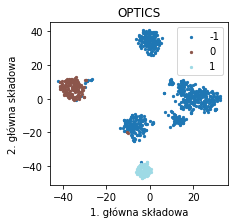

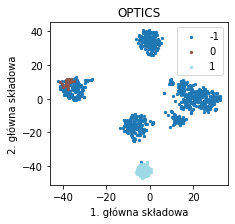

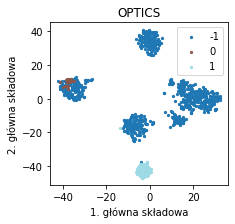

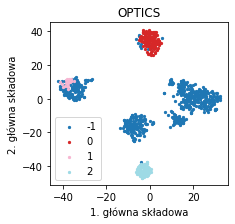

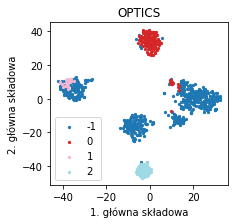

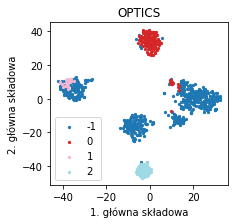

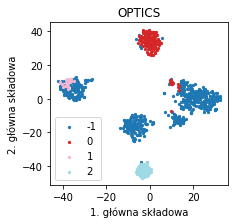

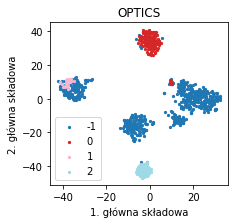

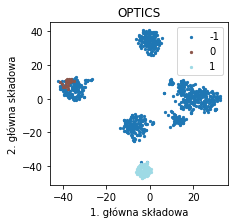

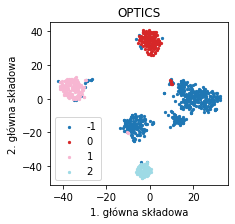

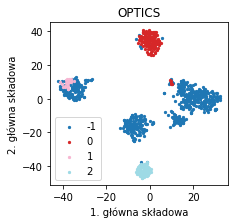

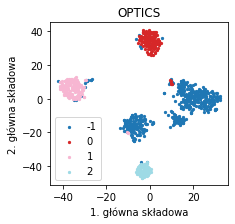

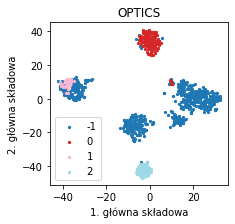

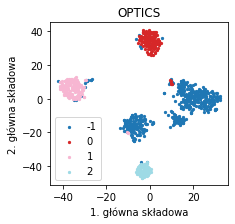

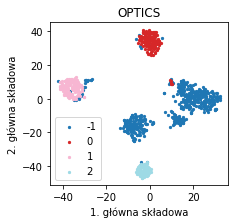

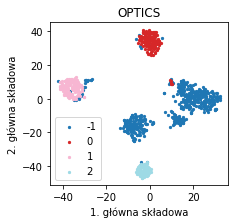

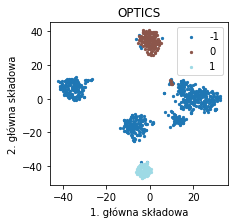

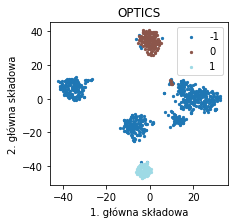

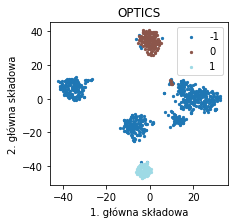

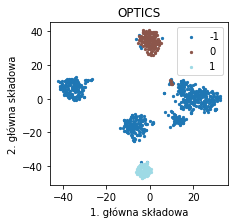

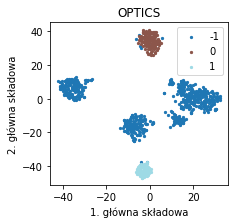

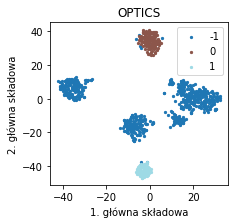

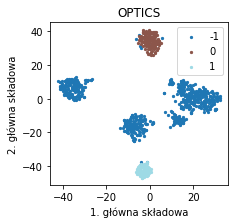

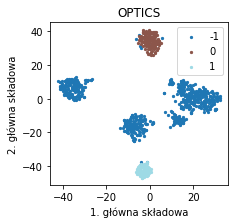

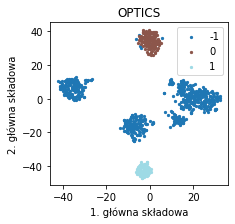

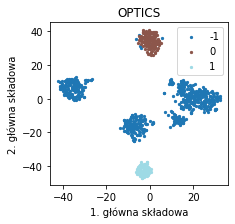

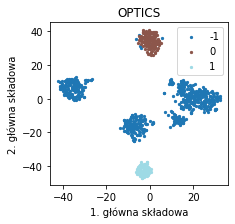

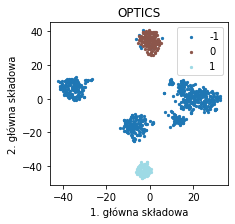

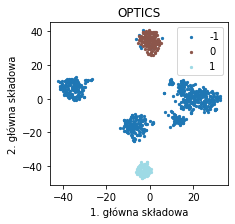

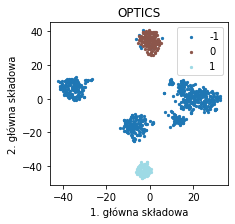

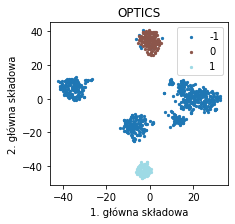

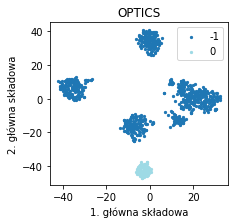

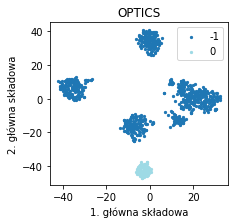

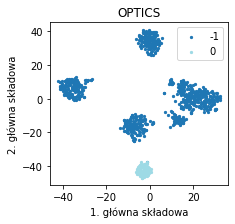

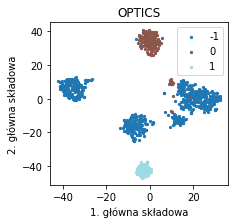

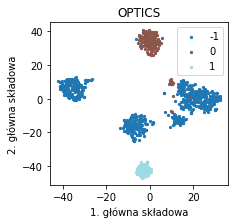

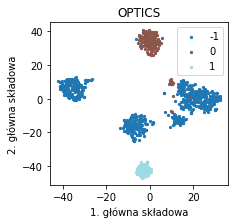

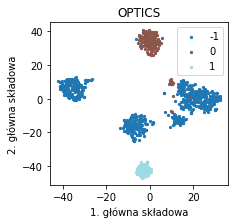

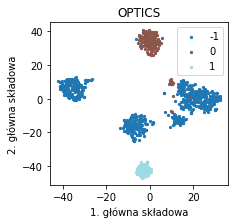

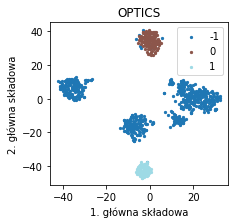

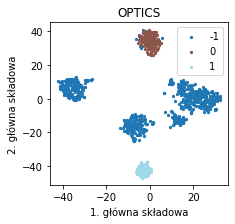

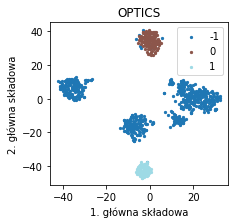

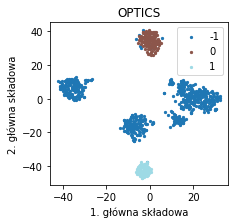

In [49]:
for min_pts in range(2,60,1):
    print('min_pts = ', min_pts)
    optics = OPTICS(min_samples = min_pts, metric ='correlation').fit(data_PCA)
    scatterPlot(x_tsne, y_tsne, optics.labels_,"OPTICS", size = (4,3))
    print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%\n")

<AxesSubplot:title={'center':'OPTICS'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

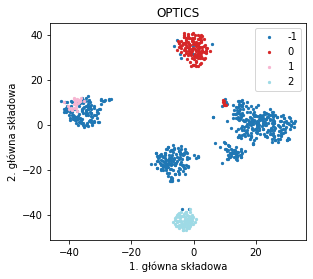

In [50]:
# In[45]:
optics_corr = OPTICS(min_samples = 24, metric ='correlation').fit(data_PCA)
scatterPlot(x_tsne, y_tsne, optics_corr.labels_,"OPTICS", size =(5.75,4))
#plt.plot(np.arange(1,802),optics_corr.reachability_[optics_corr.ordering_])

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,-1,699,39.6,7.7,18.6,18.2,15.9
1,0,4,0.0,0.0,0.0,0.0,100.0
2,1,3,0.0,0.0,0.0,0.0,100.0
3,2,3,0.0,0.0,0.0,0.0,100.0
4,3,4,0.0,0.0,0.0,0.0,100.0
5,4,4,0.0,0.0,0.0,0.0,100.0
6,5,3,0.0,0.0,0.0,0.0,100.0
7,6,2,0.0,0.0,0.0,0.0,100.0
8,7,2,0.0,0.0,0.0,0.0,100.0
9,8,2,100.0,0.0,0.0,0.0,0.0


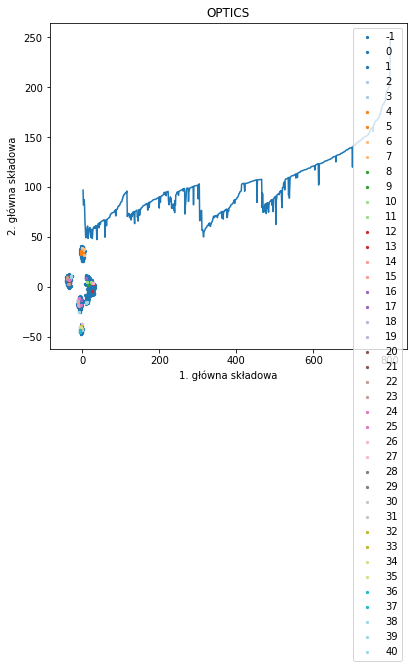

In [51]:
optics_euc = OPTICS(min_samples =2, metric = 'euclidean').fit(data_PCA)
scatterPlot(x_tsne, y_tsne, optics_euc.labels_,"OPTICS", size = (8,6))
plt.plot(np.arange(1,802),optics_euc.reachability_[optics_euc.ordering_])
analyzeClusters(optics_euc.labels_, real_labels)

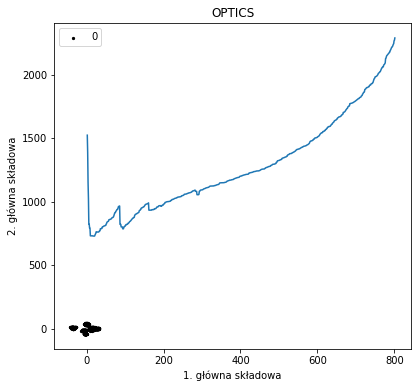

In [52]:
optics_man = OPTICS(min_samples = 9, metric = 'manhattan').fit(data_PCA)
scatterPlot(x_tsne, y_tsne, optics_man.labels_,"OPTICS", size = (8,6))
plt.plot(np.arange(1,802),
optics_man.reachability_[optics_man.ordering_])

In [53]:
analyzeClusters(optics_corr.labels_, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,-1,565,51.7,0.5,21.4,25.0,1.4
1,0,136,5.9,0.0,0.0,0.0,94.1
2,1,25,0.0,0.0,100.0,0.0,0.0
3,2,75,0.0,100.0,0.0,0.0,0.0


In [55]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
agg = AgglomerativeClustering(distance_threshold=650, n_clusters=None,linkage = 'ward',).fit(data_PCA)

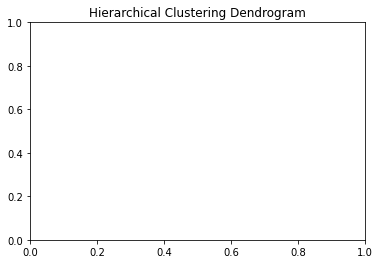

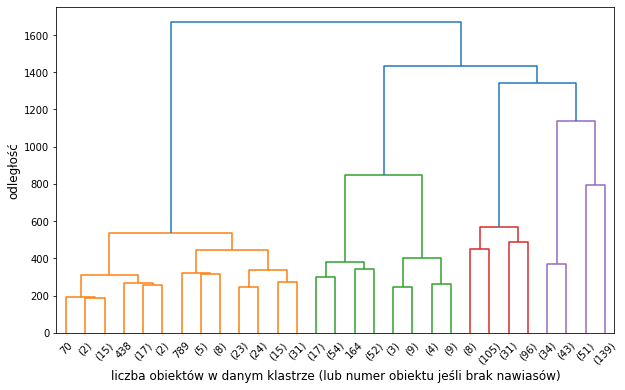

In [57]:
# plot the top three levels of the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plt.figure(figsize = (10,6))
plt.xlabel("liczba obiektów w danym klastrze (lub numer obiektu jeśli brak nawiasów)", fontsize = 12)
plt.ylabel("odległość", fontsize = 12)
plt.xticks(fontsize = 12)
plotDendrogram(agg, truncate_mode='level', p=4)

<AxesSubplot:title={'center':'Klasteryzacja aglomeracyjna'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

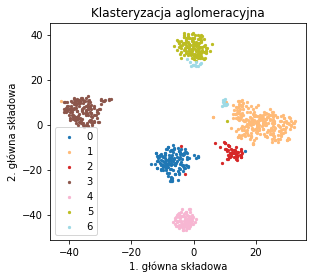

In [58]:
scatterPlot(x_tsne, y_tsne, agg.labels_,"Klasteryzacja aglomeracyjna",
size = (5.75,4))

In [59]:
analyzeClusters(agg.labels_, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,0,139,0.7,0.7,0.0,98.6,0.0
1,1,240,99.6,0.0,0.4,0.0,0.0
2,2,51,92.2,0.0,0.0,7.8,0.0
3,3,145,0.0,0.0,100.0,0.0,0.0
4,4,77,0.0,100.0,0.0,0.0,0.0
5,5,124,0.0,0.0,0.0,0.0,100.0
6,6,25,52.0,0.0,0.0,0.0,48.0


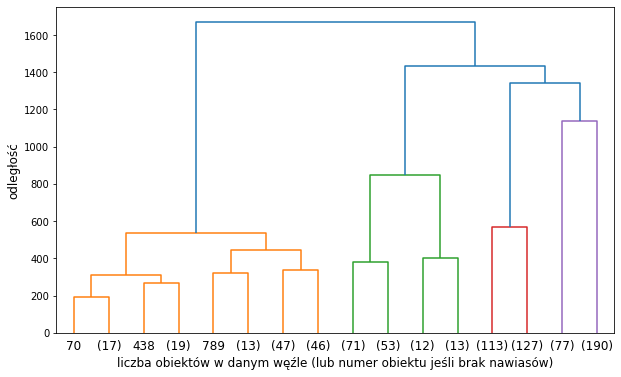

In [62]:
agg = AgglomerativeClustering(distance_threshold=1000, n_clusters =
None, linkage = 'ward',affinity = 'euclidean').fit(data_PCA)
plt.figure(figsize = (10,6))
plotDendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("liczba obiektów w danym węźle (lub numer obiektu jeśli brak nawiasów)", fontsize = 12)
plt.ylabel("odległość", fontsize = 12)
plt.xticks(fontsize = 12)
plt.show()

<AxesSubplot:title={'center':'Klasteryzacja aglomeracyjna'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

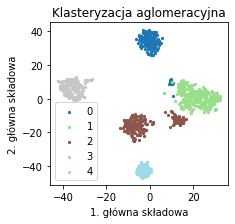

In [63]:
scatterPlot(x_tsne, y_tsne, agg.labels_,"Klasteryzacja aglomeracyjna")

In [64]:
analyzeClusters(agg.labels_, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,0,149,8.7,0.0,0.0,0.0,91.3
1,1,240,99.6,0.0,0.4,0.0,0.0
2,2,190,25.3,0.5,0.0,74.2,0.0
3,3,145,0.0,0.0,100.0,0.0,0.0
4,4,77,0.0,100.0,0.0,0.0,0.0


In [67]:
from sklearn.mixture import GaussianMixture
gaussian_labels = GaussianMixture(n_components=5,random_state=42).fit(data_PCA).predict(data_PCA)

<AxesSubplot:title={'center':'gmm tied'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

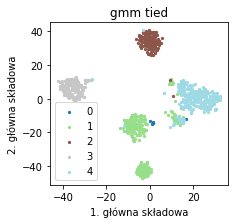

In [68]:
scatterPlot(x_tsne, y_tsne, gaussian_labels,"gmm tied",)

In [69]:
analyzeClusters(gaussian_labels, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,0,6,16.7,16.7,0.0,66.7,0.0
1,1,258,17.8,29.8,0.0,52.3,0.0
2,2,136,0.7,0.0,0.0,0.0,99.3
3,3,145,0.0,0.0,100.0,0.0,0.0
4,4,256,98.4,0.0,0.4,0.8,0.4


In [73]:
labels_arr = []
n_com_ran = range(2,21)

for n_com in n_com_ran:
    gaussian_labels = GaussianMixture(n_components = n_com, random_state=42, n_init = 5, verbose =0).fit(data_PCA).predict(data_PCA)
    labels_arr.append(gaussian_labels)
    
silhuette_scores, CH_scores, DB_scores = evalScores(data_PCA[:, :100],labels_arr)

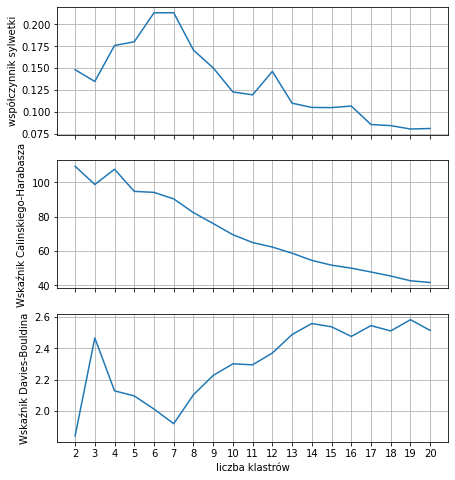

In [74]:
fig, (silhuette, CH, DB) = plt.subplots(nrows=3, figsize=(7, 8),
ncols=1, sharex=True)
silhuette.plot(n_com_ran, silhuette_scores)
silhuette.grid()
silhuette.set_ylabel(ylabel = "współczynnik sylwetki")
CH.plot(n_com_ran, CH_scores)
CH.grid()
CH.set_ylabel(ylabel = "Wskaźnik Calinskiego-Harabasza")
DB.plot(n_com_ran, DB_scores)
DB.grid()
DB.set_xlabel(xlabel = "liczba klastrów")
DB.set_ylabel(ylabel = "Wskaźnik Davies-Bouldina")
DB.set_xticks(np.arange(2,21))

In [75]:
gaussian_labels = GaussianMixture(n_components = 7, random_state=42,n_init = 5, verbose = 0).fit(data_PCA).predict(data_PCA)

<AxesSubplot:title={'center':' '}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

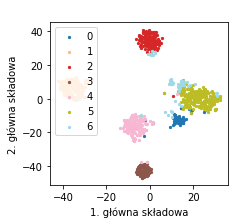

In [76]:
scatterPlot(x_tsne, y_tsne, gaussian_labels, " ")

In [77]:
analyzeClusters(gaussian_labels, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,0,55,90.9,0.0,0.0,9.1,0.0
1,1,144,0.0,0.0,100.0,0.0,0.0
2,2,126,0.0,0.0,0.0,0.0,100.0
3,3,74,0.0,100.0,0.0,0.0,0.0
4,4,141,0.7,2.8,0.7,95.7,0.0
5,5,203,100.0,0.0,0.0,0.0,0.0
6,6,58,79.3,0.0,1.7,1.7,17.2


In [78]:
gaussian_labels = GaussianMixture(n_components = 5, random_state=42,n_init = 5, verbose = 2).fit(data_PCA).predict(data_PCA)

Initialization 0
Initialization converged: True	 time lapse 0.96332s	 ll -24.37766
Initialization 1
Initialization converged: True	 time lapse 1.11264s	 ll 227.08252
Initialization 2
Initialization converged: True	 time lapse 0.87277s	 ll 216.67065
Initialization 3
Initialization converged: True	 time lapse 0.76655s	 ll 216.67065
Initialization 4
Initialization converged: True	 time lapse 0.66657s	 ll 178.54810


<AxesSubplot:title={'center':' '}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

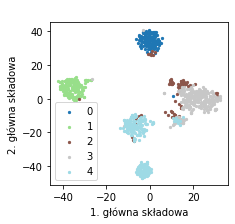

In [79]:
scatterPlot(x_tsne, y_tsne, gaussian_labels, " ")

In [80]:
analyzeClusters(gaussian_labels, real_labels)

,klaster,liczba obiektów,BRCA,COAD,KIRC,LUAD,PRAD
0,0,126,0.0,0.0,0.0,0.0,100.0
1,1,144,0.0,0.0,100.0,0.0,0.0
2,2,77,76.6,0.0,1.3,10.4,11.7
3,3,233,98.3,0.0,0.4,0.9,0.4
4,4,221,5.4,35.3,0.0,59.3,0.0


In [91]:
get_ipython().run_line_magic('matplotlib', 'inline')

In [92]:
def swap_lab(labels, x,y):
    tmp = labels
    tmp = np.where(labels==x,y,labels)
    tmp = np.where(labels==y,x,tmp)
    return tmp

<AxesSubplot:title={'center':'Klasteryzacja aglomeracyjna'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

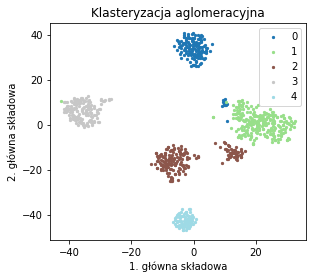

In [93]:
scatterPlot(x_tsne, y_tsne, agg.labels_,"Klasteryzacja aglomeracyjna",size = (5.75,4))

<AxesSubplot:title={'center':'Klasteryzacja aglomeracyjna'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

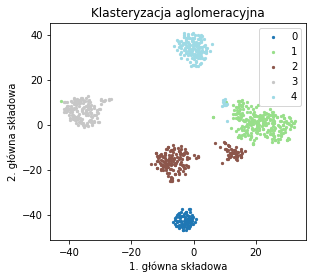

In [95]:
swapped_agg = swap_lab(agg.labels_,0,4)
scatterPlot(x_tsne, y_tsne, swapped_agg,"Klasteryzacja aglomeracyjna",size = (5.75,4))

<AxesSubplot:title={'center':'algorytm K-średnich'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

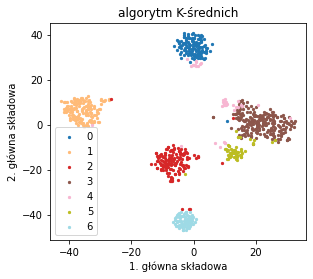

In [96]:
kmeans_lab = swap_lab(kmeans.labels_, 0, 4)
scatterPlot(x_tsne, y_tsne, kmeans_lab, "algorytm K-średnich", size =(5.75,4))

<AxesSubplot:title={'center':'algorytm GMM'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

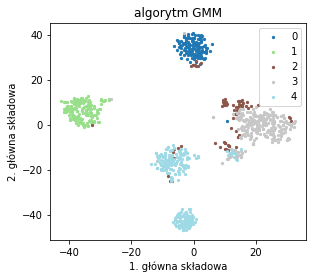

In [97]:
gaussian_labels = swap_lab(gaussian_labels,0,4)
scatterPlot(x_tsne, y_tsne, gaussian_labels, "algorytm GMM",size =(5.75,4))

<AxesSubplot:title={'center':'Rzeczywisty rodzaj próbki'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

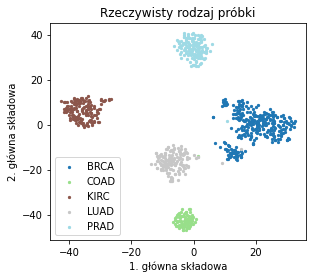

In [98]:
scatterPlot(x_tsne, y_tsne, real_labels,algoName = "Rzeczywisty rodzaj próbki", size=(5.75,4) , show_legend = True)

<AxesSubplot:title={'center':'OPTICS'}, xlabel='1. główna składowa', ylabel='2. główna składowa'>

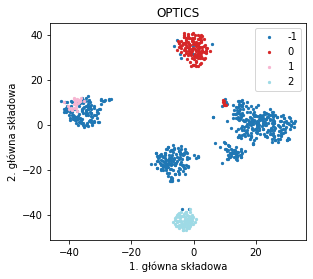

In [99]:
optics_corr = OPTICS(min_samples = 24, metric ='correlation').fit(data_PCA)
scatterPlot(x_tsne, y_tsne, optics_corr.labels_,"OPTICS",size = (5.75,4))
